# Testing package inside a notebook

In [92]:
# from graph.utils import *
# from graph.spread import *

In [199]:
def breakdown(x, num=0, full=False,return_rank=False):
    """
    Breakdown a list into chunks of sublist of size N
    """
    # Full -> size of chun is the entire list
    if full:
        num = len(x)
    # Sort the list / dict using (high -> low) values
    if isinstance(x, dict):
        ranks = pd.Series(x, index=sorted(
            x.keys()
        )).rank(method='dense', ascending=False).astype(int).sort_values()
    else:
        ranks = pd.Series(x).rank(method='dense',
                                  ascending=False).astype(int).sort_values()
    # Divide the ranks into chunk of desired size
    chunks = [list(ranks.iloc[i:i + num]) for i in range(0, len(ranks), num)]
    # Dictionary of {rank : indices}
    rank_idx = {i: set() for i in set(ranks)}
    for idx, rank in ranks.items():
        # print(f'{rank} : {idx}')
        rank_idx[rank].add(idx)
    # Create a new chunk, but index of high ranks to low ranks
    bd = []
    rs = []
    for chunk in chunks:
        x_temp = []
        for rank in chunk:
            # Picl a random index from the selected rank
            idx = rn.sample(rank_idx[rank], 1)[0]
            x_temp.append(idx)
            rank_idx.get(rank).remove(idx)
        bd.append(x_temp)
    return bd

In [221]:
import numpy as np
import pandas as pd
import random as rn
import networkx as nx

from collections import defaultdict

import seaborn as sns
import matplotlib.pyplot as plt


class SIR:
    def __init__(self, graph, beta=0.1, mu=1.0, gamma=0.0, seed=None):
        """
        Parameters
        ----------
        beta : float
            infection probability
        mu : float
            recovery probability
        beta : float
            immunization probability
        
        Instances
        ---------
        lambda_0 : float
            spreading rate
        lambda_c : float
            epidemic threshold
        tau : float
            characteristic time
        
        Note
        ----
        we assume that network has high degree heterogeneity
        i.e. k^2 > k(k+1) and in large networks both tau and
        lambda_c would become zero due to existance of hubs
        """
        self.graph = graph
        self.beta = beta
        self.mu = mu
        self.gamma = gamma
        np.random.seed(seed)
        self.itr = 0
        self.spread = 0.0
        self.avg_k = 0.0
        self.avg_k2 = 0.0
        self.lambda_0 = self.beta / self.mu
        self.lambda_c = 0.0
        self.tau = 0.0
        self.status = {n: 0 for n in self.graph.nodes()}
        self.I_set = set()
        self.S_set = set(self.graph.nodes())
        self.R_set = set()
        self.B_set = set()  # Blocked i.e. immunied
        self.parameter = {
            'beta': 'Infection rate',
            'mu': 'Recovery rate',
            'gamma': 'Immunization rate',
            0: 'Susceptible',
            1: 'Infected',
            2: 'Recovered',
            3: 'Immunized',
        }
        self.graph_properties()
        self.epidemic_threshold()

    def reset(self):
        self.itr = 0
        self.spread = 0.0
        self.status = {n: 0 for n in self.graph.nodes()}
        self.I_set = set()
        self.S_set = set(self.graph.nodes())
        self.R_set = set()
        self.B_set = set()
    
    def graph_properties(self):
        self.avg_k = np.mean([x for x in dict(self.graph.degree()).values()])
        self.avg_k2 = np.mean([x**2 for x in dict(self.graph.degree()).values()])

    def epidemic_threshold(self, output=False):
        # Epidemic threshold i.e. lambda_c or beta_c
        self.lambda_c = self.avg_k / (self.avg_k2 - self.avg_k)
        if output: print(f'lambda_c = {self.lambda_c}')
        return self.lambda_c
    
    def update_beta(self, ratio=1.5, output=False):
        # Update infection probability based on epidemic threshold
        self.beta = ratio * self.lambda_c
        if output: print(f'beta = {ratio} * lambda_c = {self.beta}')
        return self.beta

    def characteristic_time(self, output=False):
        # CT is the time that 1/e fraction (about 36%) of all susceptible individuals
        # Become Infected based on average degree and other graph properties
        self.tau = self.avg_k / ((self.beta * self.avg_k2)-((self.mu+self.beta)*self.avg_k))
        if output: print(f'tau = {self.tau}')
        return self.tau
    
    def reproductive_number(self, output=False):
        # The higher is R_0, the faster is the spreading process
        # Since beta and mu are constant we want to decrease <k> as much as possible
        r_0 = self.beta * self.avg_k / self.mu
        if putput: print(f'R_0 = {r_0}')
        return r_0

    def infect(self):
        return True if np.random.uniform(0.0, 1.0) < self.beta else False

    def recover(self):
        return True if np.random.uniform(0.0, 1.0) < self.mu else False

    def update_S(self):
        # (1) Susceptible excludes recovered
        # Recovered nodes won't get infected again = SIR
        self.S_set = set(self.graph.nodes()).difference(self.I_set).difference(
            self.R_set
        ).difference(self.B_set)
        # (2) Susceptible includes recovered
        # Recovered nodes can get infected again = SIS
        # self.S_set = set(self.graph.nodes()).difference(self.I_set).difference(self.B_set)

    def update_I(self, I_new=None):
        if I_new is not None:
            # Add newly infected to infected set
            self.I_set.update(I_new)

    def update_R(self, R_new=None):
        if R_new is not None:
            # Remove recovered from infected set
            self.I_set = self.I_set.difference(R_new)
            # Add recovered nodes to recovered group
            self.R_set.update(R_new)

    def update_spread(self):
        self.spread = len(self.R_set) / self.graph.number_of_nodes()

    def start(self, infected=None, infected_num=1, output=False):
        # At the beginning of simulation
        # Infect first node(s) to infect, from the input list or randomly
        if self.itr == 0:
            if infected is None:
                if infected_num < 1:
                    # Infected ratio is set
                    infected_num = int(
                        infected_num * self.graph.number_of_nodes()
                    )
                infected = list(
                    np.random.choice(
                        self.graph.nodes(), size=infected_num, replace=False
                    )
                )
            self.I_set.update(infected)
            self.S_set.difference(infected)
            for node in infected:
                self.status[node] = 1
            if output:
                print('Iteration = 0')
                # print('Number of Infected =', len(self.I_set))
                print('Patient zero =', self.I_set)
                print('---')

    def run(
        self,
        steps=1,
        infected=None,
        recovered=None,
        immunized=None,
        output=False,
    ):
        # Manually add new infected nodes
        if infected is not None:
            self.I_set.update(infected)

        # Manually recover some of infected nodes
        if recovered is not None:
            self.R_set.update(recovered)

        # Manually immunie or heal some of nodes
        if immunized is not None:
            self.B_set.update(immunized)
        else:
            # Randomly immune node(s) based on gamma
            immunized = list(
                np.random.choice(
                    self.graph.nodes(),
                    size=int(self.gamma * self.graph.number_of_nodes()),
                    replace=False
                )
            )

        # Step counter of this run
        t = 0
        while len(self.I_set) > 0:
            # Current infected nodes
            I = self.I_set.copy()
            # Nodes that may recover
            R = set()
            StoI = set()
            ItoR = set()
            # Start infecttion
            for i in I:
                # Look at neighbors of infected node
                for n in set(self.graph.neighbors(i)).intersection(self.S_set):
                    if self.infect():
                        # Add to newly infected set
                        StoI.add(n)
                # Node may recover later based on mu parameter
                R.add(i)
            # Start recovery
            for i in R:
                if self.recover():
                    ItoR.add(i)
            # At this point, 1 time step is completed
            # Update variables
            self.update_I(StoI)
            self.update_R(ItoR)
            # It is important to update S after I and R
            self.update_S()
            self.update_spread()
            t += 1
            self.itr += 1
            # Stop IF ... reach the number of steps
            # Meet desired rocovered ratio or all node recoveres or no more infections
            if t % steps == 0 or len(self.I_set) == 0:
                # Output result
                if output:
                    print(f'Iteration = {self.itr}')
                    print(f'Number of Susceptible = {len(self.S_set)}')
                    print(f'Number of Infected = {len(self.I_set)}')
                    print(f'Number of Recovered = {len(self.R_set)}')
                    # print(f'Spread = {np.round(self.spread * 100,2)} %')
                    print(f'Spread = {self.spread * 100} %')
                    print('---')
                    # Report back the measures
                yield (
                    {
                        't': self.itr,
                        's': self.spread,
                        'S': self.S_set,
                        'I': self.I_set,
                        'R': self.R_set,
                        'StoI': StoI,
                        'ItoR': ItoR,
                    }
                )

    def simulate(self, p_0=None, steps=1, repeat=10):
        # Patient zero i.e. p_0 is initial infected node at the start
        results = []
        for i in range(0, repeat):
            if p_0 is not None:
                self.start(infected=p_0, output=True)
            else:
                self.start(output=True)  # Radnom patient zero
            simulation_step = [
                r['s'] for r in self.run(steps=steps, output=True)
            ]
            results.append(simulation_step[len(simulation_step) - 1])
            self.reset()
        return results

    def simulate_r(self, steps=1, repeat=10, plot=True):
        # Set every node as patient zero at every iteration
        # Average the spread score over several simulation (e.g. 10)
        scores = {}
        for node in self.graph.nodes():
            results = []
            for i in range(0, repeat):
                self.start(infected=[node])
                simulation_step = [r['s'] for r in self.run(steps=steps)]
                # Spread result from last time step
                # Where there is no infected left
                results.append(simulation_step[len(simulation_step) - 1])
                self.reset()
            scores[node] = np.mean(results)
        # Return ranked node:score
        bd = breakdown(scores,full=True)
        # Plot the scores
        if plot:
            # Sort the scores
            # (1)
            # ss = sorted(scores.items(), key=lambda kv: kv[1])
            # x, y = zip(*ss)
            # (2)
            y = bd[0][:]
            x = np.arange(0,len(y))
            fig = plt.figure(figsize=(8, 6), dpi=400)
            ax = fig.add_axes([0,0,1,1])
            ax.bar(x,y)
            plt.show()
        return scores

    def simulate_sir(self, steps=1, repeat=10):
        # Set every node as patient zero at every iteration
        # Average the spread score over several simulation (e.g. 10)
        # Set plot settings.
        plt.figure(figsize=(12, 6), dpi=400)
        N = self.graph.number_of_nodes()
        resutls = {}
        for node in self.graph.nodes():
            # results = []
            s_t = defaultdict(list)
            i_t = defaultdict(list)
            r_t = defaultdict(list)
            for i in range(0, repeat):
                self.start(infected=[node])
                for r in self.run(steps=steps):
                    s_t[r['t']].append(len(r['S']))
                    i_t[r['t']].append(len(r['I']))
                    r_t[r['t']].append(len(r['R']))
                self.reset()
            # Now time to average the results for each time step
            s_t = {k: np.mean(v) / N for k, v in s_t.items()}
            i_t = {k: np.mean(v) / N for k, v in i_t.items()}
            r_t = {k: np.mean(v) / N for k, v in r_t.items()}
            plt.plot(
                s_t.keys(),
                s_t.values(),
                color='blue',
                linewidth=0.5,
                alpha=0.5
            )
            plt.plot(
                i_t.keys(),
                i_t.values(),
                color='red',
                linewidth=0.5,
                alpha=0.5
            )
            plt.plot(
                r_t.keys(),
                r_t.values(),
                color='green',
                linewidth=0.5,
                alpha=0.5
            )
            resutls[node] = {'st': s_t, 'it': i_t, 'rt': r_t}
        plt.title("SIR Simulation")
        # plt.legend(['S', 'I', 'R'])
        plt.xlabel("Time")
        plt.ylabel("Ratio of SIR nodes")
        plt.show()
        return resutls


In [213]:
G = nx.erdos_renyi_graph(1000,0.01)

In [214]:
sir = SIR(G,beta=0.2)

In [215]:
sir.characteristic_time()


1.035117410619843

In [216]:
sir.epidemic_threshold()

0.10172557172557171

In [210]:
# fr = sir.simulate()
# fr = sir.simulate(p_0=[0])

In [222]:
fr = sir.simulate_r()

UnboundLocalError: local variable 'bd' referenced before assignment

In [ ]:
# fr = sir.simulate_all()

In [106]:
# fr

In [121]:
sorted_scores = sorted(fr.items(), key=lambda kv: kv[1], reverse=True)
# sorted_scores
sorted_scores[-1]

(583, 0.0809)

In [122]:
x,y = zip(*sorted_scores)
x[-1]

583

/home/alif/venv/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

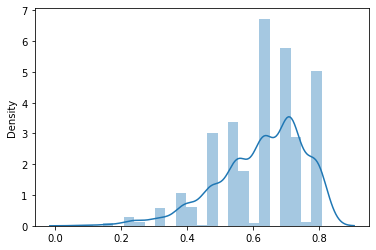

In [144]:
# plt.figure(figsize=(12,6),dpi=400)
# plt.hist(y,alpha=0.5,rwidth=0.95)
# plt.hist(y,bins=np.arange(0,1,0.1),alpha=0.5)
# plt.show()

sns.distplot(y)

In [56]:
node0 = fr[0]
node0

{'st': {1: 0.9987999999999999,
  2: 0.9965,
  3: 0.994,
  4: 0.992,
  5: 0.988,
  6: 0.988},
 'it': {1: 0.0002, 2: 0.0015, 3: 0.0025, 4: 0.002, 5: 0.001, 6: 0.0},
 'rt': {1: 0.001, 2: 0.002, 3: 0.0035, 4: 0.006, 5: 0.011, 6: 0.012}}

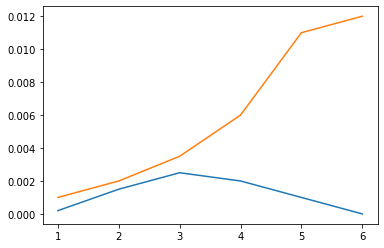

In [74]:
plt.figure()
s_t = node0['st']
i_t = node0['it']
r_t = node0['rt']
# temp = sorted(s_t.items())
# x,y = zip(*temp)
# plt.plot(x,y)
# plt.plot(s_t.keys(),s_t.values())
plt.plot(i_t.keys(),i_t.values())
plt.plot(r_t.keys(),r_t.values())
plt.show()